In [190]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
from dgl.nn.pytorch import EdgeWeightNorm
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001

e_gcn = False

e_gcn_res = False

e_graph_sage = True

e_graph_sage_res = True

e_gat = False

e_gat_res = False

In [191]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017_5_percent"
# name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
name = "nf_uq_nids"
# name = "x_iiot"

num_neighbors = [25, 10]
# num_neighbors = [4, 4]
# num_neighbors = None

with_centralities = False

node_features = False
# node_features = True
node_features_version = 2

validate = True
validate_epoch = 1

if with_centralities:
    suffix = "_with_centralities"
elif node_features:
    if node_features_version == 3:
        suffix = "_node_features_2"
    else:
        suffix = "_node_features"

else:
    suffix = ""

dataset = datasets[name]

In [192]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "num_neighbors": num_neighbors,
    "with_centralities": with_centralities,
    "node_features": node_features,
    "node_features_version": node_features_version,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}
results_final["time_elapsed"] = {}

if e_gcn:
    results_final["e_gcn"] = {}

if e_gcn_res:
    results_final["e_gcn_res"] = {}

if e_graph_sage:
    results_final["e_graph_sage"] = {}

if e_graph_sage_res:
    results_final["e_graph_sage_res"] = {}

if e_gat:
    results_final["e_gat"] = {}

if e_gat_res:
    results_final["e_gat_res"] = {}

results_final["val_accuracy"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}

results_final

{'name': 'nf_uq_nids',
 'configuration': {'num_epochs': 100,
  'batch_size': 128,
  'learning_rate': 0.001,
  'num_neighbors': [25, 10],
  'with_centralities': False,
  'node_features': True,
  'node_features_version': 2},
 'accuracy': {},
 'time_elapsed': {},
 'e_graph_sage': {},
 'e_graph_sage_res': {},
 'val_accuracy': {},
 'val_precision': {},
 'val_recall': {},
 'val_f1': {},
 'val_FPR': {},
 'val_FNR': {}}

In [193]:
def calculate_FPR_FNR(cm):

    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    return FPR, FNR

In [194]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20241210-170242'

In [195]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [196]:
with open(f"datasets/{name}/training_graph{suffix}.pkl", "rb") as f:
    G = pickle.load(f)

In [197]:
# nx.diameter(G)

In [198]:
if node_features:
    G = from_networkx(G,  edge_attrs=['h', dataset.label_col], node_attrs=["n_feats"])
else:
    G = from_networkx(G,  edge_attrs=['h', dataset.label_col])


In [199]:
num_features = G.edata['h'].shape[1]
num_features

8

In [200]:
if node_features:
    # G.ndata["h"] = th.cat([G.ndata["n_feats"], th.ones(G.num_nodes(), num_features)], dim=1)
    G.ndata["h"] = G.ndata["n_feats"]
else:
    G.ndata['h'] = th.ones(G.num_nodes(), num_features)
    
ndim_in = G.ndata["h"].shape[-1]

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, ndim_in))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [201]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(
                                                      G.edata[dataset.label_col].cpu().numpy()),
                                                  y=G.edata[dataset.label_col].cpu().numpy())

In [202]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [203]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [204]:
with open(f"datasets/{name}/testing_graph{suffix}.pkl", "rb") as f:
    G_test = pickle.load(f)

In [205]:
if node_features:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col], node_attrs=["n_feats"])  
else:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col])

In [206]:
actual_label = G_test.edata.pop(dataset.label_col)

if node_features:
    # G_test.ndata["feature"] = th.cat([G_test.ndata["n_feats"], th.ones(G_test.num_nodes(), num_features)], dim=1)
    G_test.ndata["feature"] = G_test.ndata["n_feats"]
else:
    G_test.ndata['feature'] = th.ones(G_test.num_nodes(),  num_features)

ndim_in = G_test.ndata["feature"].shape[-1]

In [207]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [208]:
def test_gnn(model, graph, norm=False):
    start_time = timeit.default_timer()

    if norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)

In [209]:
def train_gnn(model_class, Graph, residual, model_name, num_neighbors=None, norm=None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if norm:
        edge_weight = th.ones(Graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(Graph, edge_weight)
        Graph.edata['norm_weight'] = norm_edge_weight

    if num_neighbors:
        model = model_class(ndim_in, num_features, 128, F.relu,
                            dropout=0.2, num_neighbors=num_neighbors, residual=residual)
    else:
        model = model_class(ndim_in, num_features, 128, F.relu,
                            dropout=0.2, residual=residual)

    opt = th.optim.Adam(model.parameters(), lr=learning_rate)

    val_acc = []
    val_precision = []
    val_recall = []
    val_f1 = []
    val_FPR = []
    val_FNR = []
    for epoch in range(1, num_epochs):
        #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features, edge_features)
        loss = criterion(pred[train_mask], edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch, ' Training acc:', compute_accuracy(
            pred[train_mask], edge_label[train_mask]))
        if validate and epoch % validate_epoch == 0:
            actual, test_pred, elapsed = test_gnn(model, G_test, norm=True)
            cr = classification_report(actual, test_pred, digits=4, output_dict=True)
            val_acc.append(cr["accuracy"])
            val_precision.append(cr['weighted avg']['precision'])
            val_recall.append(cr['weighted avg']['recall'])
            val_f1.append(cr['weighted avg']['f1-score'])

            labels = ["Normal", "Attack"]
            cm = confusion_matrix(actual, test_pred, labels=labels)
            FPR, FNR = calculate_FPR_FNR(cm)
            val_FPR.append(FPR)
            val_FNR.append(FNR)
            print(cr["accuracy"])
    if validate:
        results_final["val_accuracy"][model_name] = val_acc
        results_final["val_precision"][model_name] = val_precision
        results_final["val_recall"][model_name] = val_recall
        results_final["val_f1"][model_name] = val_f1
        results_final["val_FPR"][model_name] = val_FPR
        results_final["val_FNR"][model_name] = val_FNR
    return model

### Training EGCN

In [210]:
if e_gcn:
    model_gcn = train_gnn(EGCN, G, False, "e_gcn", None, True)

### Training EGCN residual

In [211]:
if e_gcn_res:
    model_gcn_res = train_gnn(EGCN, G, True, "e_gcn_res", None, True)

### Training EGraphSage 

In [212]:
if e_graph_sage:
    model_sage = train_gnn(EGRAPHSAGE, G, False, "e_graph_sage", num_neighbors=num_neighbors)

Epoch: 1  Training acc: 0.43808823823928833
0.9627132005989552 seconds
0.7639990778920264
Epoch: 2  Training acc: 0.7267917990684509
0.8414512984454632 seconds
0.7946060411742337
Epoch: 3  Training acc: 0.786945641040802
0.840148501098156 seconds
0.809895386726119
Epoch: 4  Training acc: 0.8038667440414429
0.8469714000821114 seconds
0.8127319250681639
Epoch: 5  Training acc: 0.8133388757705688
0.846848402172327 seconds
0.8153158779039567
Epoch: 6  Training acc: 0.8149384260177612
1.1250810995697975 seconds
0.8204315887845821
Epoch: 7  Training acc: 0.8192012310028076
0.8298899009823799 seconds
0.8218597998205494
Epoch: 8  Training acc: 0.8179547786712646
1.0763796977698803 seconds
0.8215730391535496
Epoch: 9  Training acc: 0.8207992911338806
0.8628624007105827 seconds
0.8219256646758082
Epoch: 10  Training acc: 0.814039409160614
0.8166751004755497 seconds
0.8173927956275678
Epoch: 11  Training acc: 0.8148031234741211
0.8314432017505169 seconds
0.8155078801707019
Epoch: 12  Training acc

### Training EGraphSage residual

In [213]:
if e_graph_sage_res:
    model_sage_res = train_gnn(EGRAPHSAGE, G, True, "e_graph_sage_res", num_neighbors=num_neighbors)

Epoch: 1  Training acc: 0.7857587337493896
0.8609167002141476 seconds
0.559583460713478
Epoch: 2  Training acc: 0.5624060034751892
0.8258183002471924 seconds
0.7020572204036895
Epoch: 3  Training acc: 0.6717116236686707
0.888604398816824 seconds
0.7085303065325509
Epoch: 4  Training acc: 0.7026732563972473
1.0411343984305859 seconds
0.7356728405647973
Epoch: 5  Training acc: 0.7268489003181458
1.0368153005838394 seconds
0.7740972165263621
Epoch: 6  Training acc: 0.7806487083435059
0.872248500585556 seconds
0.8017374651724044
Epoch: 7  Training acc: 0.7946777939796448
0.8434672988951206 seconds
0.8103598582290059
Epoch: 8  Training acc: 0.8090884685516357
0.8824492990970612 seconds
0.8150536612160392
Epoch: 9  Training acc: 0.8128791451454163
0.8359497003257275 seconds
0.8160643139243275
Epoch: 10  Training acc: 0.8168044090270996
0.8749939985573292 seconds
0.8206872811236295
Epoch: 11  Training acc: 0.8184426426887512
0.8637422993779182 seconds
0.81692894549124
Epoch: 12  Training acc:

### Training EGAT

In [214]:
if e_gat:
    model_gat = train_gnn(EGAT, G, False, "e_gat", None)

### Training EGAT residual

In [215]:
if e_gat_res:
    model_gat_res = train_gnn(EGAT, G, True, "e_gat_res", None)

# Testing

In [216]:
with open(f"datasets/{name}/testing_graph{suffix}.pkl", "rb") as f:
    G_test = pickle.load(f)

In [217]:
if node_features:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col], node_attrs=["n_feats"])  
else:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col])

In [218]:
actual_label = G_test.edata.pop(dataset.label_col)

if node_features:
    # G_test.ndata["feature"] = th.cat([G_test.ndata["n_feats"], th.ones(G_test.num_nodes(), num_features)], dim=1)
    G_test.ndata["feature"] = G_test.ndata["n_feats"]
else:
    G_test.ndata['feature'] = th.ones(G_test.num_nodes(),  num_features)

ndim_in = G_test.ndata["feature"].shape[-1]

In [219]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [220]:
def test_gnn(model, graph, norm=False):
    start_time = timeit.default_timer()

    if norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)

In [221]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path=None):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [222]:
if e_gcn:
    actual, test_pred, elapsed = test_gnn(model_gcn, G_test, norm=True)

In [223]:
if e_gcn:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [224]:
if e_gcn:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gcn.png')

In [225]:
if e_gcn:
    FPR, FNR = calculate_FPR_FNR(cm)

In [226]:
if e_gcn:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gcn"]["elapsed"] = elapsed
    results_final["e_gcn"]["classification_report"] = cr
    results_final["e_gcn"]["FPR"] = FPR
    results_final["e_gcn"]["FNR"] = FNR
    results_final["accuracy"]["e_gcn"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gcn"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Testing EGCN residual

In [227]:
if e_gcn_res:
    actual, test_pred, elapsed = test_gnn(model_gcn_res, G_test, norm=True)

In [228]:
if e_gcn_res:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [229]:
if e_gcn_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gcn_res.png')

In [230]:
if e_gcn_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [231]:
if e_gcn_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gcn_res"]["elapsed"] = elapsed
    results_final["e_gcn_res"]["classification_report"] = cr
    results_final["e_gcn_res"]["FPR"] = FPR
    results_final["e_gcn_res"]["FNR"] = FNR
    results_final["accuracy"]["e_gcn_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gcn_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Testing EGraphSage

In [232]:
if e_graph_sage:
    actual, test_pred, elapsed = test_gnn(model_sage, G_test)

0.853241503238678 seconds


In [233]:
if e_graph_sage:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

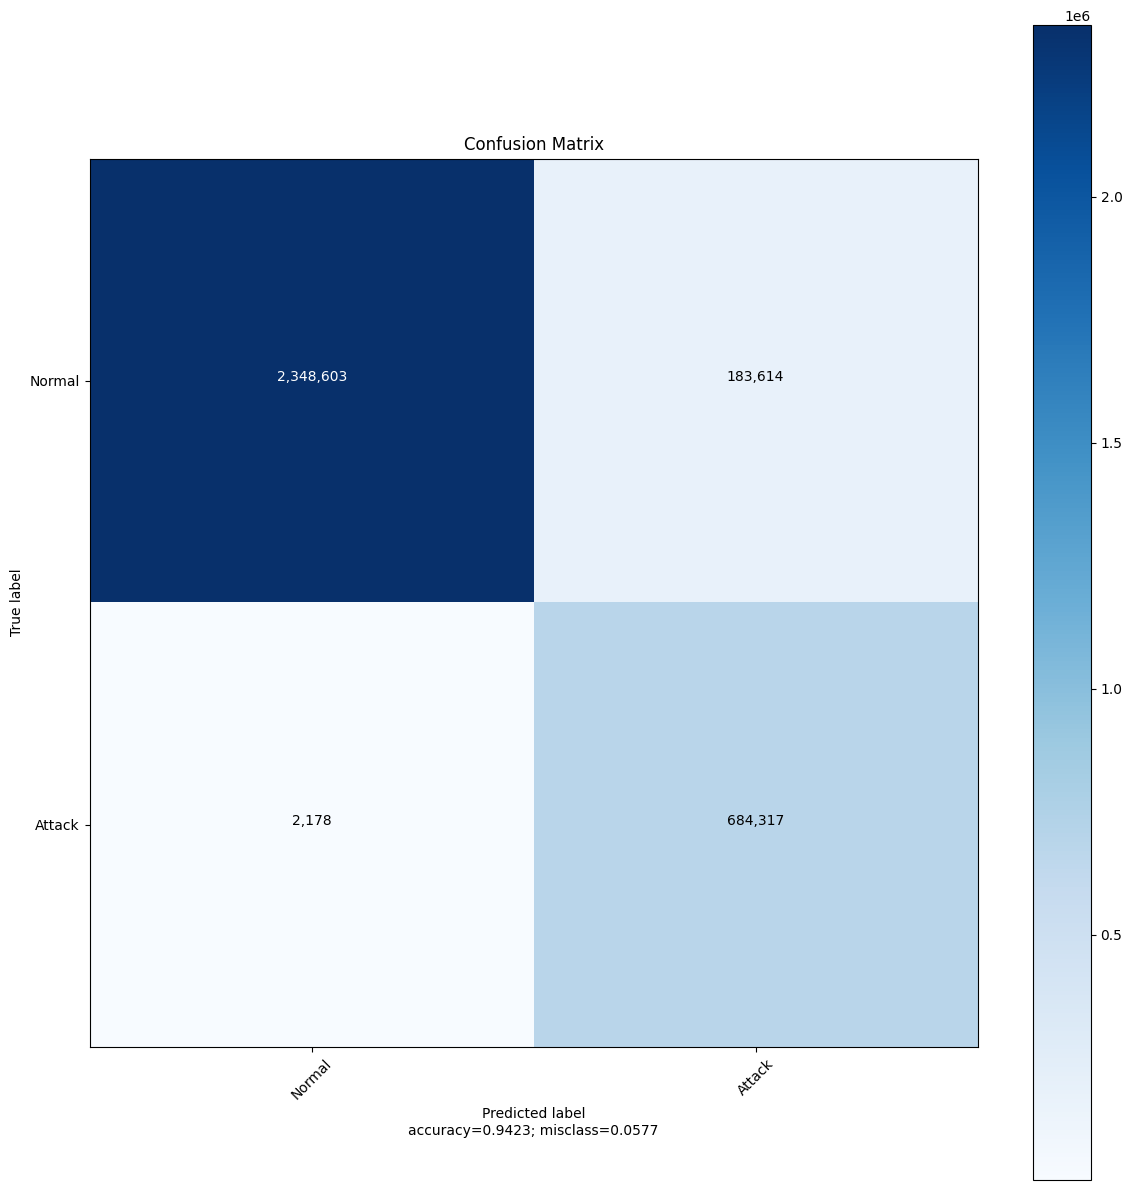

In [234]:
if e_graph_sage:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_graph_sage.png')

In [235]:
if e_graph_sage:
    FPR, FNR = calculate_FPR_FNR(cm)

In [236]:
if e_graph_sage:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_graph_sage"]["elapsed"] = elapsed
    results_final["e_graph_sage"]["classification_report"] = cr
    results_final["e_graph_sage"]["FPR"] = FPR
    results_final["e_graph_sage"]["FNR"] = FNR
    results_final["accuracy"]["e_graph_sage"] = cr["accuracy"]
    results_final["time_elapsed"]["e_graph_sage"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.7884    0.9968    0.8805    686495
      Normal     0.9991    0.9275    0.9620   2532217

    accuracy                         0.9423   3218712
   macro avg     0.8938    0.9622    0.9212   3218712
weighted avg     0.9542    0.9423    0.9446   3218712



### Testing EGraphSage residual

In [237]:
if e_graph_sage_res:
    actual, test_pred, elapsed = test_gnn(model_sage_res, G_test)

0.8676028996706009 seconds


In [238]:
if e_graph_sage_res:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

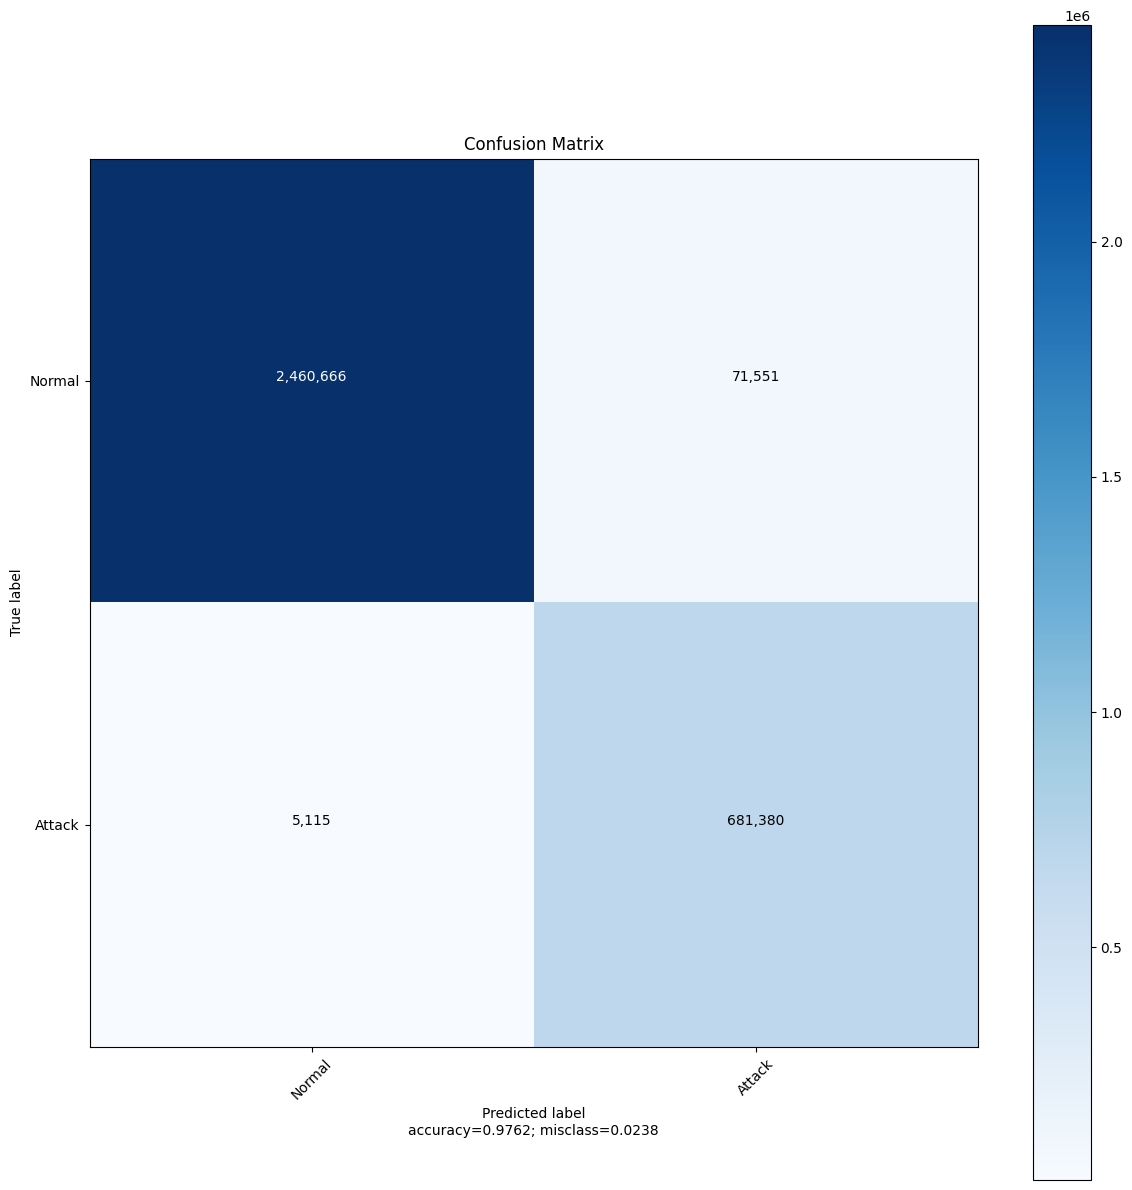

In [239]:
if e_graph_sage_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_graph_sage_res.png')

In [240]:
if e_graph_sage_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [241]:
if e_graph_sage_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_graph_sage_res"]["elapsed"] = elapsed
    results_final["e_graph_sage_res"]["classification_report"] = cr
    results_final["e_graph_sage_res"]["FPR"] = FPR
    results_final["e_graph_sage_res"]["FNR"] = FNR
    results_final["accuracy"]["e_graph_sage_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_graph_sage_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9050    0.9925    0.9467    686495
      Normal     0.9979    0.9717    0.9847   2532217

    accuracy                         0.9762   3218712
   macro avg     0.9514    0.9821    0.9657   3218712
weighted avg     0.9781    0.9762    0.9766   3218712



### Testing EGAT

In [242]:
if e_gat:
    actual, test_pred, elapsed = test_gnn(model_gat, G_test)

In [243]:
if e_gat:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [244]:
if e_gat:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gat.png')

In [245]:
if e_gat:
    FPR, FNR = calculate_FPR_FNR(cm)

In [246]:
if e_gat:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gat"]["elapsed"] = elapsed
    results_final["e_gat"]["classification_report"] = cr
    results_final["e_gat"]["FPR"] = FPR
    results_final["e_gat"]["FNR"] = FNR
    results_final["accuracy"]["e_gat"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gat"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Testing EGAT residual

In [247]:
if e_gat_res:
    actual, test_pred, elapsed = test_gnn(model_gat_res, G_test)

In [248]:
if e_gat_res:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [249]:
if e_gat_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gat_res.png')

In [250]:
if e_gat_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [251]:
if e_gat_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gat_res"]["elapsed"] = elapsed
    results_final["e_gat_res"]["classification_report"] = cr
    results_final["e_gat_res"]["FPR"] = FPR
    results_final["e_gat_res"]["FNR"] = FNR
    results_final["accuracy"]["e_gat_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gat_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Saving results

In [252]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)


filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()